In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [89]:
data = pd.read_excel('./OppScrData.xlsx', index_col=None)
data=data[data.columns[0:52]]
data.head()
clinical_col=data.columns[0:14]
outcome_col=data.columns[15:40]
CT_col=data.columns[41:52]
CT_data=data[CT_col]
CT_data=CT_data.fillna(CT_data.mean())
CT_data['Liver HU    (Median)']=pd.to_numeric(CT_data['Liver HU    (Median)'],errors='coerce')
CT_data=CT_data.fillna(CT_data.mean())
CT_data=CT_data.astype(float)

In [90]:
CL_data=data[clinical_col]
CL_data=CL_data.drop(columns=['Record ID', 'Visit ID', 'PT ID','BMI >30', 'Met Sx'])
CL_data['BMI']=CL_data['BMI'].fillna(CL_data['BMI'].mean())
(CL_data['Tobacco']=='Yes').sum()/len(CL_data)
CL_data['Tobacco']=CL_data['Tobacco'].fillna('No')
CL_data['Alcohol abuse']=CL_data['Alcohol abuse'].fillna(0)
CL_data['Alcohol abuse']=CL_data['Alcohol abuse'].apply(lambda x: 1 if x!=0 else 0)
for i in ['Sex','Tobacco']:
    CL_data[i] = pd.factorize(CL_data[i])[0] + 1
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: 0.005 if x=='<1%' else x)
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: 0.3 if x=='>30%' else x)
fm=np.mean(CL_data['FRS 10-year risk (%)'][CL_data['FRS 10-year risk (%)']!='X'])
CL_data['FRS 10-year risk (%)']=CL_data['FRS 10-year risk (%)'].apply(lambda x: fm if x=='X' else x)
for i in ['FRS 10-year risk (%)','FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)']:
    CL_data[i]=pd.to_numeric(CL_data[i],errors='coerce')
    CL_data[i]=CL_data[i].fillna(CL_data[i].mean())
CL_CT_data=pd.concat([CL_data,CT_data],axis=1)

In [91]:
X = CL_CT_data.values
training_X, testing_X = train_test_split(X, test_size = 0.2)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_X = sc.fit_transform(training_X)
testing_X = sc.transform(testing_X)

In [92]:
print (training_X.shape)
print (testing_X.shape)

(7378, 20)
(1845, 20)


In [93]:
latent_dim = 6

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='tanh'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation='tanh'),
      layers.Dense(16, activation='relu'),
      layers.Dense(np.size(X,1), activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [94]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [95]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
autoencoder.fit(training_X, training_X,
                epochs=200,
                shuffle=True,
                batch_size=16, 
                callbacks=[callback],
                validation_data=(testing_X, testing_X))

Epoch 1/200
462/462 [==============================] - 1s 2ms/step - loss: 0.0439 - val_loss: 0.0171
Epoch 2/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0123
Epoch 3/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 4/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 5/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 6/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 7/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 8/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 10/200
462/462 [==============================] - 1s 1ms/step - loss: 0.0045 - val_lo

In [97]:
blank=6000
data['DEATH [d from CT]']=data['DEATH [d from CT]'].fillna(blank)
death=data['DEATH [d from CT]'][data['DEATH [d from CT]']!=blank]
y = death.values
CL_CT_data=CL_CT_data[data['DEATH [d from CT]']!=blank]
X=CL_CT_data.values
X=sc.transform(X)

<ipython-input-97-05a2f86b0dfb>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  CL_CT_data=CL_CT_data[data['DEATH [d from CT]']!=blank]


In [99]:
np.shape(y)

(549,)

In [100]:
encodedX=autoencoder.encoder(X).numpy()
X_train, X_test ,y_train,y_test= train_test_split(encodedX, y,test_size = 0.2)

In [101]:
def KNN(train_X,train_y,test_x,K):
    dist=np.zeros(len(train_y))
    for i in range(len(train_y)):
        dist[i]=np.linalg.norm(test_x-train_X[i])
    dist_ind=dist.argsort()[0:K]
    y_lab=[]
    for i in range(K):
        y_lab.append(np.float64(train_y[dist_ind[i]]))
    return(y_lab)

In [102]:
y_pred=[]
y_lab=[]
acc=[]
kk=20
for i in range(len(y_test)):
    y_pred_all=KNN(X_train,y_train,X_test[i],kk)
    y_pred.append(np.mean(y_pred_all))
    y_lab.append(y_pred[i])
    acc.append(y_lab[i]-y_test[i])
np.absolute(acc).sum()/len(y_test)

509.7836363636362

{'whiskers': [<matplotlib.lines.Line2D at 0x243d8bfa8b0>,
 'caps': [<matplotlib.lines.Line2D at 0x243d8bfaf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x243d8bfa550>],
 'medians': [<matplotlib.lines.Line2D at 0x243d8c8e670>],
 'fliers': [<matplotlib.lines.Line2D at 0x243d8c8e970>],
 'means': []}

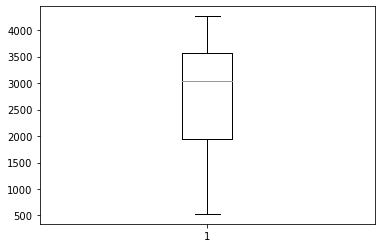

In [103]:
CL_CT_data=pd.concat([CL_data,CT_data],axis=1)
CL_CT_data_na=CL_CT_data[data['DEATH [d from CT]']==blank]
X_na=CL_CT_data.values
X_na=sc.transform(X_na)
encodedX_na=autoencoder.encoder(X_na).numpy()
y_pred_na=[]
y_lab_na=[]
acc_na=[]
kk=20
for i in range(np.shape(encodedX_na)[0]):
    y_pred_all=KNN(encodedX,y,encodedX_na[i],kk)
    y_pred_na.append(np.mean(y_pred_all))
    y_lab_na.append(y_pred_na[i])
    acc_na.append(y_lab_na[i]-X_na[i,0])
plt.boxplot(acc_na)

In [104]:
[np.quantile(acc,0.5)]

[66.57499999999993]

{'whiskers': [<matplotlib.lines.Line2D at 0x243e5c2e7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x243e5c2ee80>,
 'boxes': [<matplotlib.lines.Line2D at 0x243e5c2e460>],
 'medians': [<matplotlib.lines.Line2D at 0x243e5c24580>],
 'fliers': [<matplotlib.lines.Line2D at 0x243e5c24880>],
 'means': []}

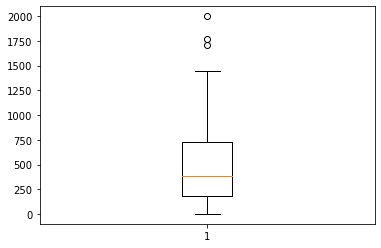

In [105]:
plt.boxplot(np.absolute(acc))